## Auswertung Zisterne Datenfiles
Datenfiles aus Zisternen-Controller auswerten

### Imports

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import pandas as pd
from sklearn import preprocessing
import os
import requests
from IPython.display import IFrame
import datetime
import re

### Daten einlesen

In [2]:
# Datensammlung einlesen
df1=pd.read_csv('Datensammlung.csv',engine='python',sep=';',decimal=',',index_col=False)
df1['Timestamp']=pd.to_datetime(df1['Date'],format='%d.%m.%Y %H:%M')
df1.tail()

,Log File,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 24h [Liter],Measured quantity change 24h [Liter],Calculated quantity change 24h [Liter],Quantity difference [%],Filter diagnosis [-],Usage in last 24h [Liter],Usage average in last 10d [Liter],Timestamp
629,181203_V310_4.csv,03.12.2018 16:17,1097,3446,98,Kein Fehler erkannt,1.51,180,14.46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-03 16:17:00
630,181203_V310_4.csv,03.12.2018 17:17,1136,3568,100,Kein Fehler erkannt,0.00,180,16.23,0.0,122.0,156.0,21.0,Verstopft,NaN,NaN,2018-12-03 17:17:00
631,181203_V310_4.csv,03.12.2018 18:17,1221,3835,98,Kein Fehler erkannt,1.81,180,18.00,0.0,267.0,157.0,0.0,OK,NaN,NaN,2018-12-03 18:17:00
632,181203_V310_4.csv,03.12.2018 19:17,1330,4178,100,Kein Fehler erkannt,0.00,180,20.65,0.0,343.0,244.0,0.0,OK,NaN,NaN,2018-12-03 19:17:00
633,181203_V310_4.csv,03.12.2018 20:17,1437,4514,100,Kein Fehler erkannt,0.00,180,22.72,0.0,336.0,186.0,0.0,OK,NaN,NaN,2018-12-03 20:17:00


### Weitere Daten lesen ab 3.12.18
Alle Daten befinden sich im unterverzeichnis ./csv. Die obigen Daten stehen im ./bak verzeichnis

In [3]:
# Aktuelle Web-Page darstellen 
IFrame(src='http://192.168.178.5', width=700, height=800)

Erst mal neue Daten lesen

In [4]:
# Programm Version bestimmen 
#<H2>Programminfo</h2><p>V3.1.0</p>
response = requests.get('http://192.168.178.5')
base_text = response.text
base_text=base_text.replace('\n','')
base_text=base_text.replace('\r','')
#x = re.match('.*<H2>Programminfo</h2><p>(\S*)</p>.*', base_text) 
x = re.search('(?<=<H2>Programminfo</h2><p>)(\S+)(?=</p>)', base_text) 
version=x.group(0)
version=version.replace('.','')

# Get data log file
response = requests.get('http://192.168.178.5/Res_Ctl.csv')
data = response.text
data=data.replace('\r\r','\r')
if (len(re.findall('\r\n',data))>1):
    filename="csv/"+datetime.datetime.now().strftime("%y%m%d%H%M%S")+"_"+version+".csv"
    text_file = open(filename, "w")
    text_file.write("%s" % data)
    text_file.close()
    print("New file saved: "+filename)
else:
    print("Received file is empty and will not be saved")

    

New file saved: csv/181215060557_V310.csv


In [5]:
# Dateien listen
newfiles=os.listdir('./csv')
newfiles

['181209165900_V310.csv',
 '181209193100_V310.csv',
 '181212175600_V310.csv',
 '181212185337_V310.csv',
 '181212203728_V310.csv',
 '181212215525_V310.csv',
 '181213191218_V310.csv',
 '181214224242_V310.csv',
 '181215060557_V310.csv']

In [6]:
#Dataframe mit allen Daten erstellen
df=df1
for nFile in newfiles:
    df2=pd.read_csv('./csv/'+nFile,engine='python',sep=';',decimal='.',index_col=False)
    df2.insert(0,'Log File',nFile)
    df2['Timestamp']=pd.to_datetime(df2['Date'],format='%Y-%m-%d %H:%M:%S')
    df=df.append(df2,sort=False)
    

#Umbenennung falsche Spaltennamen
df=df.rename(columns={"Measured quantity change 24h [Liter]": "Measured quantity change 1h [Liter]", "Calculated quantity change 24h [Liter]": "Calculated quantity change 1h [Liter]"})

df.tail()

,Log File,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 24h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Usage in last 24h [Liter],Usage average in last 10d [Liter],Timestamp
3,181215060557_V310.csv,2018-12-15 00:52:58,1743,5475,95,Kein Fehler erkannt,4.61,180,0.0,NaN,NaN,NaN,NaN,NaN,88.0,65.0,2018-12-15 00:52:58
4,181215060557_V310.csv,2018-12-15 01:53:06,1744,5478,99,Kein Fehler erkannt,1.02,180,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-15 01:53:06
5,181215060557_V310.csv,2018-12-15 02:53:14,1734,5447,100,Kein Fehler erkannt,0.00,180,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-15 02:53:14
6,181215060557_V310.csv,2018-12-15 03:53:23,1734,5447,100,Kein Fehler erkannt,0.00,180,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-15 03:53:23
7,181215060557_V310.csv,2018-12-15 04:53:31,1715,5387,100,Kein Fehler erkannt,0.00,180,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2018-12-15 04:53:31


### Formatumwandlungen

In [7]:
# Daten mit 1.1.70 entfernen
df=df.where(df['Timestamp']>'2.1.1970')

#set date as index
df.set_index('Timestamp',inplace=True)

#Strings ersetzen
df['Filter diagnosis [-]']=df['Filter diagnosis [-]'].replace('OK',1)
df['Filter diagnosis [-]']=df['Filter diagnosis [-]'].replace('Verstopft',0)


In [8]:
df.tail()

,Log File,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter],Refill quantity 24h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Usage in last 24h [Liter],Usage average in last 10d [Liter]
Timestamp,,,,,,,,,,,,,,,,
2018-12-15 00:52:58,181215060557_V310.csv,2018-12-15 00:52:58,1743,5475,95,Kein Fehler erkannt,4.61,180,0.0,NaN,NaN,NaN,NaN,NaN,88.0,65.0
2018-12-15 01:53:06,181215060557_V310.csv,2018-12-15 01:53:06,1744,5478,99,Kein Fehler erkannt,1.02,180,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-15 02:53:14,181215060557_V310.csv,2018-12-15 02:53:14,1734,5447,100,Kein Fehler erkannt,0.00,180,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-15 03:53:23,181215060557_V310.csv,2018-12-15 03:53:23,1734,5447,100,Kein Fehler erkannt,0.00,180,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-12-15 04:53:31,181215060557_V310.csv,2018-12-15 04:53:31,1715,5387,100,Kein Fehler erkannt,0.00,180,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Stündliche Regenmenge rechnen

In [9]:
df['Rain quantity 1h [Liter]']=df['Rain quantity 24h [Liter]'].diff()
df['Rain quantity 1h [Liter]']=df['Rain quantity 1h [Liter]'].clip(lower=0)

### Datensatz zerlegen 
1. Grunddaten Pegel, Menge, Nachspeisung, Regen

In [10]:
# 1. Grunddaten
dfg=df.iloc[:,0:9]
dfg.tail()

,Log File,Date,Level [mm],Quantity [Liter],Signal health [-],Error [-],StdDev [Liter],Refill Quantity [Liter],Rain quantity 24h [Liter]
Timestamp,,,,,,,,,
2018-12-15 00:52:58,181215060557_V310.csv,2018-12-15 00:52:58,1743,5475,95,Kein Fehler erkannt,4.61,180,0.0
2018-12-15 01:53:06,181215060557_V310.csv,2018-12-15 01:53:06,1744,5478,99,Kein Fehler erkannt,1.02,180,0.0
2018-12-15 02:53:14,181215060557_V310.csv,2018-12-15 02:53:14,1734,5447,100,Kein Fehler erkannt,0.00,180,0.0
2018-12-15 03:53:23,181215060557_V310.csv,2018-12-15 03:53:23,1734,5447,100,Kein Fehler erkannt,0.00,180,0.0
2018-12-15 04:53:31,181215060557_V310.csv,2018-12-15 04:53:31,1715,5387,100,Kein Fehler erkannt,0.00,180,0.0


2. Filter-Diagnosedaten

In [11]:
# 2. Filter-Diagnosedaten
# Werte auswaehlen
dfd=df.iloc[:,8:14]
dfd['Rain quantity 1h [Liter]']=df['Rain quantity 1h [Liter]']
# Werte mit Regenmenge 0 entfernen 
dfd=dfd.where(dfd['Rain quantity 1h [Liter]'] >0)
# NaNs entfernen
dfd=dfd.dropna(axis=0)
dfd.tail()

,Rain quantity 24h [Liter],Refill quantity 24h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Rain quantity 1h [Liter]
Timestamp,,,,,,,
2018-12-03 21:18:06,25.37,0.0,113.0,244.0,53.0,0.0,2.65
2018-12-04 05:19:12,27.44,0.0,128.0,97.0,0.0,1.0,1.18
2018-12-06 01:25:15,1.77,0.0,144.0,127.0,0.0,1.0,1.47
2018-12-07 20:31:10,1.18,0.0,84.0,97.0,13.0,1.0,1.18
2018-12-09 00:35:01,2.07,0.0,100.0,97.0,0.0,1.0,1.18


3. Verbrauchsberechnung

In [12]:
# 3. Verbrauchsdaten
dfv=df.iloc[:,14:16]

#Werte kleiner Null abschneiden (SW-Fehler)
dfv['Usage in last 24h [Liter]']=dfv['Usage in last 24h [Liter]'].clip(lower=0)
dfv['Usage average in last 10d [Liter]']=dfv['Usage average in last 10d [Liter]'].clip(lower=0)
dfv=dfv.where(dfv['Usage in last 24h [Liter]']>0)
# NaNs entfernen
dfv=dfv.dropna(axis=0,how='any')
dfv.tail()

,Usage in last 24h [Liter],Usage average in last 10d [Liter]
Timestamp,,
2018-11-30 00:56:00,56.0,84.0
2018-12-02 00:02:00,33.0,80.0
2018-12-06 00:25:07,25.0,70.0
2018-12-14 00:49:41,63.0,67.0
2018-12-15 00:52:58,88.0,65.0


### Pegeldaten analysieren

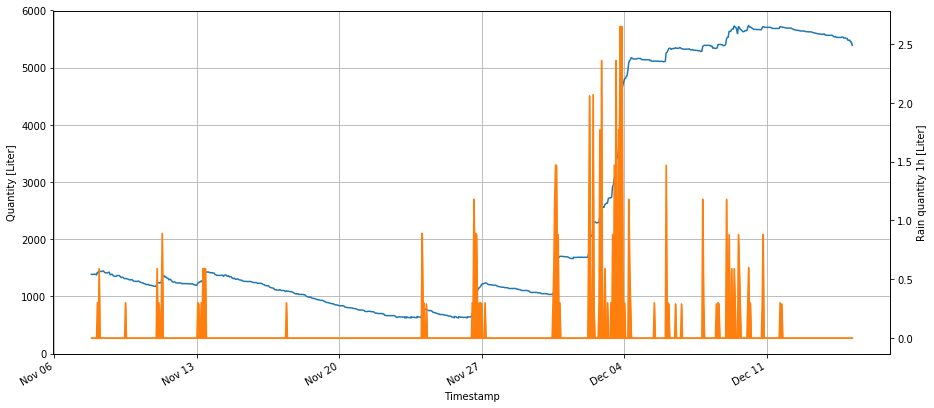

In [13]:
#plot data
fig, ax = plt.subplots(figsize=(15,7))
df['Quantity [Liter]'].plot(ax=ax,grid=True)
df['Rain quantity 1h [Liter]'].plot(ax=ax,grid=True,secondary_y=True,kind='area')

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
ax.set_ylabel('Quantity [Liter]')
plt.ylabel('Rain quantity 1h [Liter]');


### Filter-Diagnose analysieren

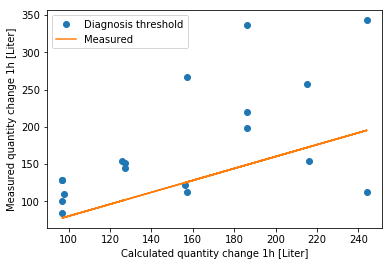

In [14]:
plt.plot(dfd['Calculated quantity change 1h [Liter]'],dfd['Measured quantity change 1h [Liter]'],'o')
plt.plot(dfd['Calculated quantity change 1h [Liter]'],0.8*dfd['Calculated quantity change 1h [Liter]'])
plt.xlabel('Calculated quantity change 1h [Liter]')
plt.ylabel('Measured quantity change 1h [Liter]')
plt.legend({'Measured','Diagnosis threshold'});

### Fehlerhafte Datenpunkte
Filterverstopfung angezeigt aber tatsächlich nicht verstopft

In [15]:
dfd_failed=dfd.where(dfd['Filter diagnosis [-]']==0).dropna(axis=0,how='any')
dfd_failed.head(20)

,Rain quantity 24h [Liter],Refill quantity 24h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Rain quantity 1h [Liter]
Timestamp,,,,,,,
2018-12-02 19:14:00,7.97,0.0,113.0,157.0,28.0,0.0,1.77
2018-12-02 21:14:00,10.33,0.0,154.0,216.0,28.0,0.0,2.36
2018-12-03 17:17:00,16.23,0.0,122.0,156.0,21.0,0.0,1.77
2018-12-03 21:18:06,25.37,0.0,113.0,244.0,53.0,0.0,2.65


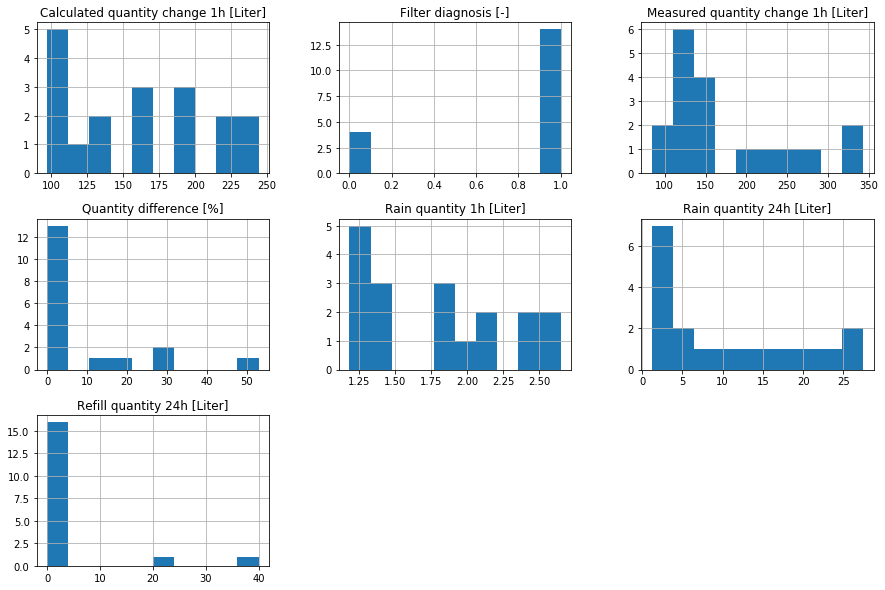

In [16]:
dfd.hist(figsize=[15, 10]);

### Filtereffizienz

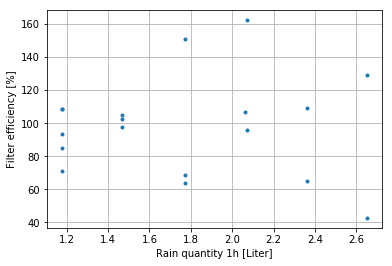

In [17]:
aRoof = 100
dfd["rEffFlt [%]"] = 100*(dfd["Measured quantity change 1h [Liter]"]/(dfd["Rain quantity 1h [Liter]"]*aRoof))
plt.plot(dfd["Rain quantity 1h [Liter]"],dfd["rEffFlt [%]"],'.');
plt.xlabel('Rain quantity 1h [Liter]')
plt.ylabel('Filter efficiency [%]')
plt.grid()

In [18]:
dfd.tail(20)

,Rain quantity 24h [Liter],Refill quantity 24h [Liter],Measured quantity change 1h [Liter],Calculated quantity change 1h [Liter],Quantity difference [%],Filter diagnosis [-],Rain quantity 1h [Liter],rEffFlt [%]
Timestamp,,,,,,,,
2018-11-26 14:47:00,1.77,40.0,110.0,98.0,0.0,1.0,1.18,93.220339
2018-11-30 13:58:00,2.07,0.0,128.0,97.0,0.0,1.0,1.18,108.474576
2018-11-30 14:58:00,3.54,0.0,151.0,127.0,0.0,1.0,1.47,102.721088
2018-11-30 15:58:00,5.01,0.0,154.0,126.0,0.0,1.0,1.47,104.761905
2018-12-02 07:03:00,2.95,20.0,220.0,186.0,0.0,1.0,2.06,106.796117
2018-12-02 11:13:00,5.61,0.0,198.0,186.0,0.0,1.0,2.07,95.652174
2018-12-02 19:14:00,7.97,0.0,113.0,157.0,28.0,0.0,1.77,63.841808
2018-12-02 21:14:00,10.33,0.0,154.0,216.0,28.0,0.0,2.36,65.254237
2018-12-03 14:17:00,13.57,0.0,258.0,215.0,0.0,1.0,2.36,109.322034


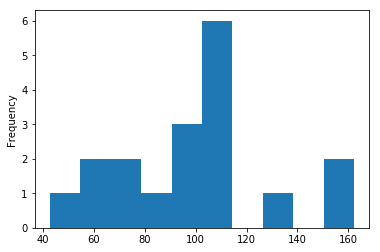

In [19]:
dfd["rEffFlt [%]"].plot(kind='hist')

### Verbrauchsberechnung

In [20]:
dfv.tail(10)

,Usage in last 24h [Liter],Usage average in last 10d [Liter]
Timestamp,,
2018-11-21 00:29:00,75.0,82.0
2018-11-22 00:32:00,60.0,79.0
2018-11-23 00:35:00,80.0,79.0
2018-11-24 00:38:00,92.0,80.0
2018-11-26 00:45:00,87.0,85.0
2018-11-30 00:56:00,56.0,84.0
2018-12-02 00:02:00,33.0,80.0
2018-12-06 00:25:07,25.0,70.0
2018-12-14 00:49:41,63.0,67.0


In [21]:
dfv.describe()

,Usage in last 24h [Liter],Usage average in last 10d [Liter]
count,17.0000,17.000000
mean,73.0000,75.882353
std,25.5196,8.350766
min,25.0000,63.000000
25%,60.0000,67.000000
50%,75.0000,79.000000
75%,88.0000,82.000000
max,120.0000,88.000000


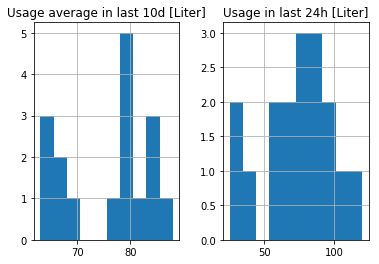

In [22]:
dfv.hist();

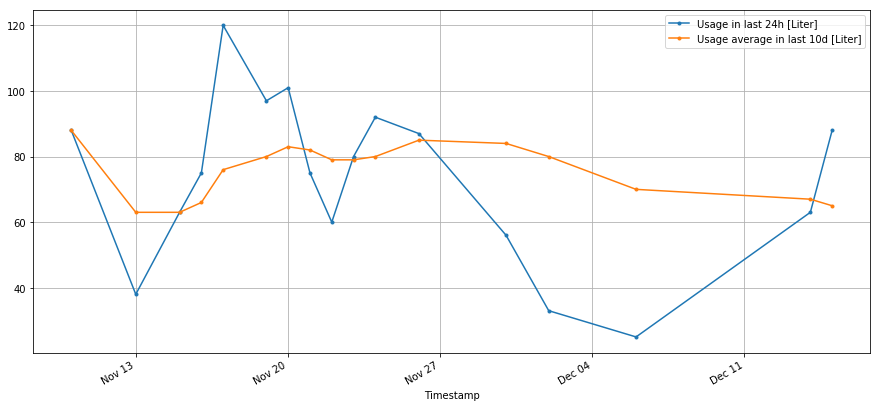

In [23]:
#plot data
fig, ax = plt.subplots(figsize=(15,7))
dfv.plot(ax=ax,grid=True,style='.-')

#set ticks every week
ax.xaxis.set_major_locator(mdates.WeekdayLocator())
#set major ticks format
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
